#### *Jacob McCright  |  Automated Insights  |  Programming Assessment for Data Science Internship  |  3/5/2018 * 

# Prompt  #1

#### This prompt asks us to find the 5 most popular genres within the given *movies* dataset.

For this prompt I will be:
-  Munging the data into a form most conducive to analyses for the given question
-  Determining which statistic (mean/median/count) is best to establish a ranking
-  Computing the ranking

We start by importing necessary modules and the dataset:

In [3]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import ast

movies = pd.read_csv("movie_data.csv")

movies.head(5)

,id,title,release_date,box_office_revenue,runtime,genres,summary
0,0,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[""Space western"", ""Horror"", ""Supernatural"", ""T...","Set in the second half of the 22nd century, th..."
1,1,White Of The Eye,1987,NaN,110.0,"[""Erotic thriller"", ""Psychological thriller"", ...",A series of murders of rich young women throug...
2,2,A Woman in Flames,1983,NaN,106.0,"[""Drama""]","Eva, an upper class housewife, becomes frustra..."
3,3,The Sorcerer's Apprentice,2002,NaN,86.0,"[""Adventure"", ""Fantasy"", ""World cinema"", ""Fami...","Every hundred years, the evil Morgana returns..."
4,4,Little city,1997-04-04,NaN,93.0,"[""Romance Film"", ""Ensemble Film"", ""Comedy-dram...","Adam, a San Francisco-based artist who works a..."


Now we want to check the type of each feature to make sure it matches our initial intuition

In [4]:
for feature in movies.columns:
    print(feature, "...", type(movies[feature][0]))

id ... <class 'numpy.int64'>
title ... <class 'str'>
release_date ... <class 'str'>
box_office_revenue ... <class 'numpy.float64'>
runtime ... <class 'numpy.float64'>
genres ... <class 'str'>
summary ... <class 'str'>


We can see that "genres" is actually a string and not a list. Let's change it into a list!

## Munging

We convert list-looking strings into lists using ast's "literal_eval" method.

In [5]:
movies['genres'] = pd.Series(ast.literal_eval(genres) for genres in movies['genres'])

#Let's check our work:
type(movies['genres'][0])

list

Next we split by genres so each movie has a row for each genre it falls under. This allows us to more easily work with the data and ask genre-centric questions of the data.

__Note__: All of these list comprehensions make us prone to memory errors. Though my small laptop can handle it given I am not running a bunch of processes elsewhere in Jupyter.

In [6]:
#all_genres stores all the genres split out of the lists and stacks horizontally
#This makes is easy to construct our dataframe later
all_genres = np.hstack(movies.genres)

#Each feature is stacked so that a value repeats for as many genres as were in the original genre list
all_titles = np.hstack([[title]*len(genre) for title, genre in movies[['title', 'genres']].values])
all_release_dates = np.hstack([[release]*len(genre) for release, genre in movies[['release_date', 'genres']].values])
all_revenues = np.hstack([[revenue]*len(genre) for revenue, genre in movies[['box_office_revenue', 'genres']].values])
all_runtimes = np.hstack([[runtime]*len(genre) for runtime, genre in movies[['runtime', 'genres']].values])
all_summaries = np.hstack([[summary]*len(genre) for summary, genre in movies[['summary', 'genres']].values])

movies_split = pd.DataFrame({'genres':all_genres, 'titles':all_titles, 'release_date':all_release_dates,
                     'box_office_revenue':all_revenues, 'runtime':all_runtimes, 'summary':all_summaries})

#Let's check to see if this yields what we expect...
movies_split.head(10)

,box_office_revenue,genres,release_date,runtime,summary,titles
0,14010832.0,Space western,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
1,14010832.0,Horror,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
2,14010832.0,Supernatural,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
3,14010832.0,Thriller,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
4,14010832.0,Science Fiction,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
5,14010832.0,Action,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
6,14010832.0,Adventure,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
7,NaN,Erotic thriller,1987,110.0,A series of murders of rich young women throug...,White Of The Eye
8,NaN,Psychological thriller,1987,110.0,A series of murders of rich young women throug...,White Of The Eye
9,NaN,Thriller,1987,110.0,A series of murders of rich young women throug...,White Of The Eye


Next we want to look at what the actual genres are. To save the reader from a ton of scrolling we should hide the output showing all unique genres.

In [7]:
unique_genres = list(set(all_genres))

print(len(unique_genres))

unique_genres;

363


Note there are 363 unique genres. Looking at the set of genres we can see there are a number of genres that are the same for all intents and purposes just spelled slightly differently or are synonyms to other genres.

Using the tools provided by the package "fuzzywuzzy" we can create a mapping dictionary to replace certain genre labels. Here is a good examply of the two different function we will use from fuzzywuzzy:

In [20]:
#Each of these is a member of unique_genres

#partial_ratio matches on substrings and is good for matching things like: "New York Mets" and "Mets"
print("Using \"family\" and \"family-oriented\" - partial_ratio: ", fuzz.partial_ratio("family", "family-oriented"))
print("")

#ratio just looks at the minimum edit, or Levenshtein, distance from one string to another.
#We can see that it does not perform well on  string pairs that partial_ratio does.
print("Using \"family\" and \"family-oriented\" - ratio: ", fuzz.ratio("family", "family-oriented"))
print("")

#Here we see a case where ratio is appropriate
print("Using \"documentary\" and \"documetary\" - ratio: ", fuzz.ratio("documentary", "documetary"))

Using "family" and "family-oriented" - partial_ratio:  100

Using "family" and "family-oriented" - ratio:  57

Using "documentary" and "documetary" - ratio:  95


Using these two string matching metrics we construct a mapping dictionary. We use this as a temp so that the next dictionary will only have non-empty genre-to-genre mapping elements.

In [21]:
temp_mapper = {genre : [] for genre in unique_genres}

for i in range(len(unique_genres)):
    for j in range(len(unique_genres)):
        
        if i != j:
            ratio_score = fuzz.ratio(unique_genres[i],unique_genres[j])
            partial_score = fuzz.partial_ratio(unique_genres[i],unique_genres[j])
            
            #We choose the threshold here to be restrictive in ratio and very restrictive in partial_ratio
            #These values were found though trial and error
            if ratio_score >= 85 or partial_score == 100:
                temp_mapper[unique_genres[i]].append(unique_genres[j])

#After looking through temp_mapper we can find an appropriate mapping visually
genre_mapper = {"Action": "Action/Adventure", "Adventure": "Action/Adventure", "Music": "Musical",
               "Computer Animation": "Animation", "Animated Cartoon": "Animation", "Backstage Musical": "Musical",
               "Beach Party film": "Beach Film", "Biographical Film": "Biography", "Biopic [feature]": "Biography",
               "Breakdance": "Dance", "Alien invasion": "Alien Film", "Children\'s/Family": "Children\'s",
               "Children\'s Entertainment": "Children\'s", "Children\'s Fantsy": "Children\'s", 
               "Children\'s Issues": "Children\'s", "Comdedy": "Comedy", "Comedy horror": "Horror Comedy",
               "Comedy film": "Comedy", "Coming-of-age film": "Coming of age", "Detective Fiction": "Detective",
               "Education": "Educational", "Extreme Sports": "Sports", "Gross-out film": "Gross out",
               "World History": "History", "Humour": "Comedy", "Monster movie": "Monster", "Prison film": "Prison",
               "Superhero movie": "Superhero", "Sword and sorcery films": "Sword and sorcery", 
               "Romantic": "Romance Film"}

When choosing the mapping we left appropriately specific deviations from a more general genre (e.g. Pyschological Thriller doesn't get mapped to Thriller) but we did bucket things like Humour -> Comedy. Manual creation was necessary since fuzzywuzzy was being too overzealous in its matching and we would have been left with improper combinations. Also note we replace each key-genre with each value-genre.

In [22]:
#Here we implement the mapping
movies_split['genres'].replace(genre_mapper, inplace = True)

#We also want to drop duplicate rows where a given movie has both the genre mapped to and from in 'genres'
movies_split = movies_split.drop_duplicates()
movies_split.head(10)

,box_office_revenue,genres,release_date,runtime,summary,titles
0,14010832.0,Space western,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
1,14010832.0,Horror,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
2,14010832.0,Supernatural,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
3,14010832.0,Thriller,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
4,14010832.0,Science Fiction,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
5,14010832.0,Action/Adventure,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
7,NaN,Erotic thriller,1987,110.0,A series of murders of rich young women throug...,White Of The Eye
8,NaN,Psychological thriller,1987,110.0,A series of murders of rich young women throug...,White Of The Eye
9,NaN,Thriller,1987,110.0,A series of murders of rich young women throug...,White Of The Eye
10,NaN,Drama,1983,106.0,"Eva, an upper class housewife, becomes frustra...",A Woman in Flames


Awesome! Now that we have our data in a format that lends itself to analyses of the genres let's look at how we will define and quantify "popular"

## Establishing a measure of Popularity

There are a few different metrics we could use to quantify popularity from the data we are given.
- The mean box office revenue across all movies in a genre
- The median box office revenue acorss all movies in a genre
- The number of times a given genre appears in our dataset

The reasoning for this last measure would be that, given the sampling from Wikipedia was random, it roughly represents the actual population of movies. If so, it would make some sense that a more popular genre would have more movies made in that genre than a less popular genre. Hence, the higher the count of occurrences for a given genre, the more popular.

To begin let's take a look at the distributions of box office revenues for a few genres to see if mean might be a good statistcal descriptor. Let's look at a few genres with the highest sample sizes.

In [27]:
movies_split['genres'].groupby(movies_split['genres']).count().nlargest(20)

genres
Drama               19134
Comedy              12140
Action/Adventure     8483
Romance Film         6666
Thriller             6530
World cinema         5153
Crime Fiction        4275
Horror               4082
Black-and-white      3731
Indie                3668
Family Film          3219
Short Film           3192
Musical              2687
Romantic drama       2572
Animation            2480
Science Fiction      2339
Mystery              2119
Romantic comedy      2075
Fantasy              2012
Crime Thriller       1682
Name: genres, dtype: int64

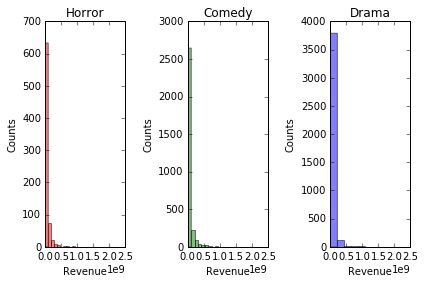

In [30]:
horror_revenue = movies_split[movies_split['genres'] == 'Horror']['box_office_revenue'].dropna()

comedy_revenue = movies_split[movies_split['genres'] == 'Comedy']['box_office_revenue'].dropna()

drama_revenue = movies_split[movies_split['genres'] == 'Drama']['box_office_revenue'].dropna()

fig, ax = plt.subplots(1,3, sharex=True)

ax[0].hist(horror_revenue, alpha = 0.5, color = 'r')
ax[0].set_title('Horror')
ax[0].set_ylabel('Counts')
ax[0].set_xlabel("Revenue")

ax[1].hist(comedy_revenue, alpha = 0.5, color = 'g')
ax[1].set_title('Comedy')
ax[1].set_ylabel("Counts")
ax[1].set_xlabel("Revenue")

ax[2].hist(drama_revenue, alpha = 0.5, color = 'b')
ax[2].set_title('Drama')
ax[2].set_ylabel("Counts")
ax[2].set_xlabel("Revenue")

plt.tight_layout()
plt.show()

Taking a look at the plots above we can see that the vast majority of box office revenues are found at the lower end of the range. Also we see that for each genre plotted there are a few significant outliers which indicates that the mean will be greatly affected by these outliers. Because of this we assume that either median or genre-count are better overall descriptions of popularity via box office revenue.

In [31]:
#Let's take a look at the top 20 genres and see if they align with out intuition (i.e. Comedy/Drama/etc...)
movies_split['box_office_revenue'].groupby(movies_split['genres']).median().nlargest(20)


genres
Space opera                                 475106177.0
Movies About Gladiators                     457640427.0
Archaeology                                 401128639.0
Educational                                 399755374.0
Reboot                                      385494555.0
Revisionist Fairy Tale                      350367551.5
Point of view shot                          248639099.0
Sci-Fi Thriller                             214796484.5
Archives and records                        209701562.5
Period Horror                               206071502.0
Sci-Fi Adventure                            196567262.0
Private military company                    171407179.0
Glamorized Spy Film                         160000000.0
Apocalyptic and post-apocalyptic fiction    157091718.0
Master Criminal Films                       152945555.5
Auto racing                                 151027274.5
Live action                                 148947455.0
Buddy cop                                

This does not match our intuition whatsoever! I have never heard of anyone going to a "Space Opera, which certainly wouldn't be true for the actual most popular genre.

Let's look at count and see what we find.

In [32]:
movies_split['box_office_revenue'].groupby(movies_split['genres']).count().nlargest(20)

genres
Drama               3953
Comedy              3051
Action/Adventure    2382
Thriller            1877
Romance Film        1863
Crime Fiction       1187
Indie                946
Romantic comedy      827
Family Film          810
Horror               749
Romantic drama       708
Fantasy              676
Mystery              652
Science Fiction      627
Period piece         616
Film adaptation      566
Crime Thriller       550
Musical              523
World cinema         522
Comedy-drama         516
Name: box_office_revenue, dtype: int64

This list makes the most sense certainly. 7,587 of our 42,204 movies have non-empty values for box office revenue. The movie industry is all about serving a market just like any other industry and because of this it is easy to see that here in our movie dataset demand dictates supply. By looking at what we are assuming is a random sample of the supply we can reason that frequency of genre occurrance is directly related to consumer demand which is again directly related to "popularity". For clarity and finality here are the top 5 most "popular" genres assuming demand = popularity in descending order:

- Drama
- Comedy
- Action/Adventure
- Romance film
- Thriller

# Prompt  #2

#### What words are characteristic of the movie summaries in those genres?

For this prompt I will be:
-  First associating each word with a part-of-speech (POS) tag while still in its original context
-  Using POS tags to lemmatize words
-  Compute Term Frequency - Inverse Document Frequency scores for the lemmatized corpus
-  Parse POS distribution for each genre
-  Display and interpret top TF-IDF scores
-  Explore Latent Dirichlet Allocation (LDA) to determine genres' "topics"

We start by importing necessary modules and the dataset (Prompts were tackled separately and so we need a different structure with *movies*):

In [34]:
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from stop_words import get_stop_words
from gensim import corpora, models
import gensim

movies = pd.read_csv("movie_data.csv")

movies['genres'] = pd.Series(ast.literal_eval(genres) for genres in movies['genres'])

movies.head(5)

,id,title,release_date,box_office_revenue,runtime,genres,summary
0,0,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Space western, Horror, Supernatural, Thriller...","Set in the second half of the 22nd century, th..."
1,1,White Of The Eye,1987,NaN,110.0,"[Erotic thriller, Psychological thriller, Thri...",A series of murders of rich young women throug...
2,2,A Woman in Flames,1983,NaN,106.0,[Drama],"Eva, an upper class housewife, becomes frustra..."
3,3,The Sorcerer's Apprentice,2002,NaN,86.0,"[Adventure, Fantasy, World cinema, Family Film]","Every hundred years, the evil Morgana returns..."
4,4,Little city,1997-04-04,NaN,93.0,"[Romance Film, Ensemble Film, Comedy-drama, Co...","Adam, a San Francisco-based artist who works a..."


## POS Tags

First we want to group summaries of the same genre together. Note there is no reasonable way for us to create disjoint groups, hence we allow a movie to belong to more than one genre grouping. 

In this process we also want to take the opportunity to add part-of-speech (POS) tags to each word. We can only determine an individual word's speech tag (e.g. Verb, Adjective, etc) when we observe it in context. As linguist J.R. Firth said, "*You shall know a word by the company it keeps.*" The POS tags will allow us to lemmatize the words (Further explained below).

In [35]:
unique_genres = ["Drama", "Comedy", "Action/Adventure", "Romance Film", "Thriller"]

genres_list = {genre: [] for genre in unique_genres}

for genre in unique_genres:
    for genres, summary in zip(movies['genres'], movies['summary']):
        
        if genre in genres:
            
            #NLTK's pos_tag returns the word and its POS tag
            genres_list[genre].append(nltk.pos_tag(summary.split()))

The following functions help with the necessary translations required when using the NLTK's lemmatizer.

In [36]:
#get_wordnet_pos maps tags from NLTK's pos_tag to tags utilized in the lemmatizing method.
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
#Used to associate lemmatized tag object to literal string name
def tag_helper(word,tag):
    wnl = WordNetLemmatizer()
    wntag = get_wordnet_pos(tag)
    
    #Not supply tag in case of None
    if wntag is None:
        lemma = wnl.lemmatize(word)
        tb_tag = ""
        
    #Assigning a variable to the english equivalent of our tags
    else:
        lemma = wnl.lemmatize(word, pos = wntag)
        if wntag == wordnet.ADJ:
            tb_tag = "Adjective"
        elif wntag == wordnet.VERB:
            tb_tag = "Verb"
        elif wntag == wordnet.NOUN:
            tb_tag = "Noun"
        elif wntag == wordnet.ADV:
            tb_tag = "Adverb"
        elif wntag is None:
            tb_tag = ""
            
    return lemma, tb_tag

## Lemmatization

Now we use lemmatization to bring words up a level in abstraction and away from their more specific use. By lemmatizing a corpus of words we reduce the morphological variation. For instance, "better" becomes "good", "running" and "ran" become "run", "frustrated" maps to "frustrate", and so on. By aggregating words into their base form we can come to more accurate characterizations through the term-frequency inverse document-frequency (TF-IDF) score. 

Further, since parts-of-speech are necessary for lemmatization we are able to characterize genres' words by POS distribution. (e.g. Is the proportion of verbs used in Action/Adventure different than Comedy?)

In [38]:
#Genre name is key with list of lemmed summaries (in list form)
lem_dict = {} 

#Same structure as lem_dict but with POS
tag_dict ={} 

#We count the number of times we successfully map a word to its lemmatized form just to satisfy curiosity
lem_count = 0
for genre,tup_list in genres_list.items():
    
    #list that contains all lemmed summaries for a given genre
    temp_lem = [] 
    temp_pos = []
    for summary in tup_list:
            
        #list of lemmed words for a given summary
        summary_lem = [] 
        summary_pos = []

        for tup in summary:

            _word, _tag = tup
            #Leave out proper nouns (NNP), plural proper nouns (NNPS), and personal pronouns (PRP)
            if str(_tag) != "NNP" or str(_tag) != "NNPS" or str(_tag) != "PRP" or str(_tag) != "PRP$":
                #We let compound words stay as is (e.g. chimney-sweep)
                _word = _word.lower().replace(".", "").strip('"!,')

                #Performs lemmatization and converts POS tag into full form (e.g. "Adjective", "Noun", etc)
                lemma, tag = tag_helper(_word, _tag) 

                #Counter to see how many words we changed
                if lemma != _word:
                    lem_count += 1
                    
                if lemma != "":    
                    summary_lem.append(lemma)
                    summary_pos.append(tag)

        temp_lem.append(summary_lem)
        temp_pos.append(summary_pos)

    lem_dict[genre] = temp_lem
    tag_dict[genre] = temp_pos
    
print("Number of words converted to their lemmatized form:", lem_count)     

Number of words converted to their lemmatized form: 2743978


## TF-IDF

We can now compute the TF-IDF score for the lemmas. We start by computing term frequency of each lemma across all summaries and follow up by counting how many summaries ("documents") each lemma appears in. We use raw term count rather than actual term frequency as we are only concered with ranking and so they are proportionally equivalent.

__Note__: In the previous code block we threw out all proper nouns, singular and plural, and also all personal pronouns. Since movie characters' names can be used numerous times in an individual movie's summary but not in any other movie's summary it necessarily has a high TF-IDF score. Without discarding proper nouns much of the top n highest TF-IDF scores belonged to words that did not help us characterize genres whatsoever.

In [39]:
#Building vocab set now helps us simply do dict comprehensions and slightly simplifies tf and df dict creation
vocab = set()
for genre, summaries in lem_dict.items():
    for summary in summaries:
        for word in summary:
            vocab.add(word)
            
vocab = list(vocab)


tf = {genre: {word: 0 for word in vocab} for genre in unique_genres}
df = {genre: {word: 0 for word in vocab} for genre in unique_genres}

for genre, summaries in lem_dict.items():
    for summary in summaries:
        
        #We create a temp docuement frequency list to ensure that even if a word shows up multiple times in...
        #...a document it is only counted in df once
        temp_df = []
        
        for word in summary:
            tf[genre][word] += 1
            
            #Had we not used temp_df here we would just be counting like tf
            if word not in temp_df:
                df[genre][word] += 1
                temp_df.append(word)
                
tf_idf = {genre: {word: 0 for word in vocab} for genre in unique_genres}

for genre in unique_genres:
    for word in vocab:
        
        #We use 1 + the number of documents a word has appeared to avoid division by 0 in the idf term
        tf_idf[genre][word] = tf[genre][word] * np.log(len(lem_dict[genre]) / (1 + df[genre][word]))
        
print("Total unique words in corpus:",len(vocab))

Total unique words in corpus: 177611


Before dissecting TF-IDF scores let's consider what the part-of-speech make-up is for the genres. When looking at the distribution of parts-of-speech across genres it's best to look at intra-distributions proportionally considering there is large variation in number of summaries.

In [40]:
pos_counts = {genre: {} for genre in unique_genres}

#Building out the totals for each part-of-speech for each genre
for genre in unique_genres:
    for tags in tag_dict[genre]:
        for tag in tags:
            if tag != "":
                pos_counts[genre][tag] = pos_counts[genre].get(tag, 0) + 1

#Here we normalize the totals so we can compare proportions across genres
for genre, pos_dict in pos_counts.items():
    temp_total = 0
    
    #Summing pos counts
    for parts in pos_dict.values():
        temp_total += parts
    
    #Normalizing
    for types in pos_dict.keys():
        pos_counts[genre][types] = pos_counts[genre][types] / temp_total
    
for genre, types in pos_counts.items():
    print("{}:".format(genre))
    
    for pos, res in types.items():
        print(pos, ": ", "{}%".format(round(100*res,2)))
        
    print("...")
    print("...")       

Romance Film:
Adjective :  10.15%
Noun :  52.26%
Adverb :  6.55%
Verb :  31.05%
...
...
Comedy:
Adjective :  10.01%
Noun :  53.18%
Adverb :  6.5%
Verb :  30.32%
...
...
Drama:
Adjective :  10.42%
Noun :  52.93%
Adverb :  6.19%
Verb :  30.47%
...
...
Action/Adventure:
Adjective :  9.39%
Noun :  54.64%
Adverb :  5.67%
Verb :  30.3%
...
...
Thriller:
Adjective :  9.52%
Noun :  53.32%
Adverb :  5.92%
Verb :  31.23%
...
...


Perhaps not so surprisingly there are no significant differences across genres in types of speech used. We therefore must rely and look to the words themselves to differentiate and characterize genres.
***
Now back to the TF-IDF scores. Let's look at the highest scoring 30 words from each genre.

In [41]:
top_words = {genre: None for genre in unique_genres}

for genre in unique_genres:
    temp_top = sorted(tf_idf[genre], key=tf_idf[genre].get, reverse=True)[:100]
    temp_top = [word for word in temp_top if word != ""]
    top_words[genre] = temp_top

#This forces jupyter to display all rows
pd.set_option('display.max_rows', None)

top_100 = pd.DataFrame.from_dict(top_words)
top_100;

Looking at the dataframe below we can see some interesting results. To save the reader from some scrolling here are noteworthy words that seem to characterize the genres in line with our intuition.

Note the listings are given in descending order according to TF-IDF rank.
***
 - __Action/Adventure__: - Kill, - Police, - Gang, - Fight, - Shoot, - Escape, - Attack, - Money, - Agent, - Gun, - Order, - Force, - Ship, - Officer, - Death, and even a very specific Action/Adeventure hero - Bond.
<br><br> 
 - __Comedy__: - Leave, - Kill, - Family, - Friend, - House, - Love, - School, - Money, - Mother, - Work, - Help, - Bug
<br><br>
 - __Drama__: - Kill, - Father, - Leave, - Love, - Family, - Mother, - Home, - House, - Return, - Friend, - Son, - Life, - Police, - Child, - Work, - Wife, - Money, - School, - Daughter
<br><br>
 - __Romance Film__: - Father, - Leave, - Love, - Family, - Mother, - Return, - Friend, - Marry, - Home, - House, - Kill, - Life, - Time, - Relationship, - Son, - Help
<br><br>
 - __Thriller__: - Kill, - Police, - House, - Car, - Leave, - Escape, - Shoot, - Father, - Murder, - Money, - Attack, - Return, - Home, - Meet, -Body, - Reveal, - Time, - Death, - Run, - Family, - Gun, - Mother

Action/Adventure and Thriller both seem to be characterized well as genres by their high-scoring TF-IDF words. It would come as no surprise for a Action/Adventure summary to mention police, gangs, fights, killings, shots, escapes, attacks, agents, and etc. These words actually seem to do a relatively good job describing some of the genres in toto.

Though it is obvious some genres highlighted words seem to match their respective genre better than others. Comedy for instance doesn't really have any truly defining characteristic words for their summaries. Which makes some sense seeing as how comedies plots are less constrained than say a Thriller's is. I would be hard-pressed to come up with defining general characteristics of a comedy's summary.

As seen in the list $alike$ below, every genre actually shares 65 of their 100 characterizing words. Most of these words are easy to understand being used frequently in descriptions of any stories. Yet some of them convey information about what summaries overall, and hence the movies themselves, are about. Generally these genres contain themes about friendship, killing, new meetings, returning to what once was, and families. Or at least that's what these characterizing words, along with a vague understanding of movie narratives, point to.

In [42]:
alike = set(top_100[unique_genres[0]])

for i in range(len(unique_genres)):
    if i != len(unique_genres) - 1:
        alike = alike.intersection(set(top_100[unique_genres[i + 1]]))
        
print(alike)

{'which', 'their', 'new', 'time', 'do', 'find', 'give', 'be', 'all', 'they', 'out', 'one', 'make', 'while', 'two', 'by', 'see', 'back', 'help', 'an', 'about', 'get', 'will', 'return', 'then', 'her', 'but', 'before', 'where', 'go', 'kill', 'from', 'not', 'father', 'that', 'his', 'man', 'she', 'up', 'when', 'at', 'after', 'into', 'off', 'have', 'with', 'this', 'begin', 'leave', 'it', 'film', 'family', 'tell', 'he', 'meet', 'on', 'them', 'him', 'take', 'who', 'for', 'come', 'try', 'friend'}


## LDA

Now let's explore the genres using Latent Dirichlet Allocation (LDA). LDA assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. So since LDA assumes that a document is created with certain topic proportion rules, its goal is to backtrack and determine which topics would lead to the given documents.

In [43]:
en_stop = get_stop_words('en')

#For LDA we take the lemmed summaries from above and simply remove stop-words
lda_dict = {}
for genre, summaries in lem_dict.items():
    temp_summaries = []
    for summary in summaries:
        temp_summary = []
        for word in summary:
            if word not in en_stop and word != "":
                temp_summary.append(word)
                
        temp_summaries.append(temp_summary)
        
    lda_dict[genre] = temp_summaries

In [44]:
dict_dict = {}
corpus_dict = {}
ldamodels = []

for genre in unique_genres:
    
    #Dictionary traverses summaries assigning a unique id to each token while collecting word counts
    dict_dict[genre] = corpora.Dictionary(lda_dict[genre])
    
    #Here we create a bag-of-words model from our Dictionary structures just created
    corpus_dict[genre] = [dict_dict[genre].doc2bow(text) for text in lda_dict[genre]]
    
    #Our corpus_dict contains Document-term matrices for each genre. We now find the LDA models
    ldamodels.append(gensim.models.ldamodel.LdaModel(corpus_dict[genre], num_topics = 3, 
                                                         id2word = dict_dict[genre], passes = 20))
    

The following results show us possible topic distribution models used to create the summaries found in our data. Though largely ambiguous, the models are slightly telling and somewhat relate to our intuitive understanding of these genres.

For example in Action/Adventure we see "kill", "take", "one" and "find" show up, which makes sense for a vague description for many movies that fall under this genre. A character must "find" some treasure, "take" back some secret plans from the enemy, or "kill" the villain to save the day. "Kill", "police", "find", and "take" seems reasonable for a Thriller by this same logic. Also note under Romance Film each of the topics contains "love", which we should definitely expect for such a genre.

In [45]:
for i in range(len(ldamodels)):
    print(unique_genres[i])
    print(ldamodels[i].print_topics(num_topics = 3, num_words = 4))
    print("...")
    print("...")

Drama
[(0, '0.006*"go" + 0.006*"tell" + 0.006*"find" + 0.005*"get"'), (1, '0.008*"love" + 0.006*"get" + 0.006*"life" + 0.006*"family"'), (2, '0.006*"kill" + 0.004*"take" + 0.004*"war" + 0.004*"one"')]
...
...
Comedy
[(0, '0.005*"film" + 0.004*"one" + 0.004*"take" + 0.004*"find"'), (1, '0.005*"back" + 0.005*"find" + 0.005*"get" + 0.005*"take"'), (2, '0.008*"get" + 0.007*"go" + 0.006*"tell" + 0.005*"find"')]
...
...
Action/Adventure
[(0, '0.006*"kill" + 0.005*"take" + 0.004*"find" + 0.004*"one"'), (1, '0.007*"kill" + 0.006*"take" + 0.005*"find" + 0.005*"go"'), (2, '0.007*"kill" + 0.005*"take" + 0.005*"find" + 0.004*"fight"')]
...
...
Romance Film
[(0, '0.005*"love" + 0.004*"take" + 0.004*"return" + 0.004*"find"'), (1, '0.012*"love" + 0.009*"get" + 0.006*"go" + 0.005*"marry"'), (2, '0.006*"go" + 0.006*"get" + 0.006*"tell" + 0.005*"find"')]
...
...
Thriller
[(0, '0.008*"kill" + 0.004*"take" + 0.004*"find" + 0.004*"escape"'), (1, '0.008*"find" + 0.007*"kill" + 0.006*"tell" + 0.006*"go"'), (

# Prompt #3

#### An empirical observation known as Zipf’s law is often used to describe the distribution of word frequencies in text corpora. Do you see evidence of Zipf’s law in the summaries?

For this prompt I will be:

 - Tokenizing the corpus of summaries
 - Finding frequency counts for each word
 - Enumerating and ordering those frequency counts
 - Looking at both qualitative and quantitave measures in search of evidence for the presence of Zipfian distribution
 
First note that Zipf's law states the a word's frequency is inversely proportional to its rank in the frequency table. E.g. if and is rank 3 is occurs 1/3 the amount of times that the highest ranked word occurs. This case represents when the parameter s = 1 where occurrance is $1/n^{s}$ amount the highest rank. Other datasets see a Zipfian distribution with differing s.

In [21]:
#Our last necessary import!
from scipy.stats import kstest
from scipy import stats

To begin let's make a dictionary with words as keys and total count across the entire corpus as values. We use the same tokenizer as in our first question.

In [2]:
def tokenizer(blob):
    #translator removes certain punctuation for us, though more must be included in assignment of tokenized
    translator = str.maketrans({key: None for key in string.punctuation})
    tokenized = blob.lower().replace("-"," ").strip('"-\'«').translate(translator).split()
    
    return tokenized

In [3]:
counts = {}

#Creating a simple dict with words as keys with counts for values
for summary in movies['summary']:
    for word in tokenizer(summary):
        counts[word] = counts.get(word, 0) + 1

Now dictionaries are inherently orderless but we need an ordering to establish rank. We can do this by creating a list of $(rank, word, count)$ tuples starting with rank 1 and descending all the way down to rank $len(counts)$.

We also create "zipf" which is a list constructed to perfectly follow Zipf's distribution using our corpus and starting with the starting value found in our data.

In [4]:
#sorted ensures we see ordered data. This ordering is preserved in future list comprehensions
ordered = [(n + 1, word, counts[word]) for n, word in enumerate(sorted(counts, key=counts.get, reverse = True))]

zipf = [(n + 1, word, max(counts.values())/(n + 1)) 
        for n, word in enumerate(sorted(counts, key=counts.get, reverse = True))]

Before we get into any quantitative measures for evidence of Zipf's law occurring in our data, first let's look at log-normed plots of both $ordered$ and $zipf$ to see if they look anywhere close to each other.

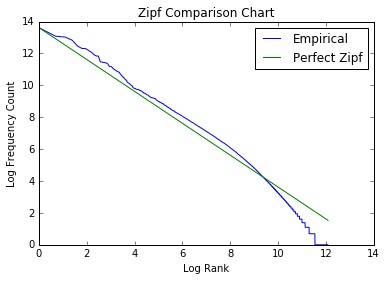

In [7]:
x_ordered = np.log([xs[0] for xs in ordered])
y_ordered = np.log([ys[2] for ys in ordered])

x_perfect = np.log([xs[0] for xs in zipf])
y_perfect = np.log([ys[2] for ys in zipf])

plt.title("Zipf Comparison Chart")
plt.xlabel("Log Rank")
plt.ylabel("Log Frequency Count")

plt.plot(x_ordered, y_ordered)
plt.plot(x_perfect, y_perfect)
plt.legend(["Empirical", "Perfect Zipf"], loc = "upper right")
plt.show()

Good news so far! Simply looking at the plot seems to give us an indication that our data follows Zipf's distribution.

Quantitatively establishing this relation is somewhat trickier though. Despite being my first impulse, running a regression on the logged empirical data and testing the alternative hypothesis that $\hat{\beta}_{1} = -1$ is actually not a statistically sound method according to the literature. See articles *Testing for Zipf’s law: A common pitfall* or *A simple* and *efficient test for Zipf’s law* from Economic Letters.

Instead our best route is to use the two-sided __[Kolmogorov–Smirnov test](hhttps://en.m.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)__ (KS). The two-sided KS test quantifies the distance between two empirical distribution functions. Essentially we are testing if two sets of data were drawn from the same distribution. For our two samples we use the ordered counts list created above from the corpus of summaries and the manufactured ordered list that perfectly relates our data as the inverse of its rank. I.e. 2nd index of tuples found in lists $ordered$ and $zipf$ or the data that constitutes the blue and green lines in the above plot.

The null hypothesis for the KS test is that the samples *are* drawn from the same samples.

In [20]:
stats.ks_2samp([xs[2] for xs in ordered], [int(xs[2]) for xs in zipf])

Ks_2sampResult(statistic=0.6165939602037658, pvalue=0.0)

Unfortunately according to the two-sided KS test we reject the null hypothesis with high confidence considering the p-value essentially equals 0. It's important to keep in mind that even though our log-log plot seems to show something very close to a Zipf distribution it's not too difficult to get log-log plots to look very close for varying distributions.

Also when we actually look at the empirical counts we can visually tell that it doesn't seem to be very Zipf-like. Early on it has a couple substantial jumps but slows down very quickly and the vast majority of the data actually sees very small differences from one rank to the next.